In [1]:
import os
import sys
import torch
import torch.optim as optim
from torch.utils.data import random_split, DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

import numpy as np
import pandas as pd
from scipy import linalg
import pickle
import tqdm
import matplotlib.pyplot as plt

In [2]:
root = os.path.dirname(os.path.dirname(os.path.realpath('__file__')))
sys.path.insert(0, os.path.join(root, 'src'))

from dataset.synthetic_ecg import generate_ecg
from cs.wavelet_basis import wavelet_basis
from cs.supports import find_support_TSOC
from cs.training_metrics import compute_metrics, update_metrics
from cs.loss import multiclass_loss_alpha
from models.tsoc import TSOC
from cs import CompressedSensing, generate_sensing_matrix

# <span style="color: red;">TODO</span>
<!-- - Which training hyperparameters should I use: ``optimizer``, ``batch_size``, ``learning_rate``?
- Will we use callback functions? -->
<!-- - Use training data from JETCAS -->
- Check model structure
- Should I scale $X$ before training?

# <span style="color: red;">The notebook is behind with respect to the experiments/tsoc_training.py </span>

## Setup

In [3]:
n = 128
m = 32
epochs = 500
lr = 0.1
batch_size = 50
N = 2_000_000
basis = 'sym6'       
fs = 256                # sampling rate
heart_rate = (60, 100)  # min and max heart rate
isnr = 35               # signal-to-noise ratio in dB (35)
seed = 0            # random seed for ECG generation
processes = 48
threshold = 0.5
gpu = 3
train_fraction = 0.9
factor = 0.2
min_lr = 0.001

min_delta = 1e-4
patience = 40

## Seeds

In [4]:
np.random.seed(seed)

# Set the seed for PyTorch (CPU)
torch.manual_seed(seed)

# Set the seed for PyTorch (GPU)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # For multi-GPU setups

## GPU

In [5]:
device = torch.device(f'cuda:{gpu}' if torch.cuda.is_available() else 'cpu')

## Data

In [6]:
# load or generate train data
namefile = os.path.join('../../newpenny/dnn-cs/JETCAS2020/data/',f'n{n}_ISNR', f'trSet_n={n}_isnr={isnr}_no-sparse.h5')
with pd.HDFStore(namefile, mode='r') as store:
    X = store.select('X').values.squeeze()

# file_name = f'ecg_train_N={N}_n={n}_fs={fs}_hr={heart_rate[0]}-{heart_rate[1]}'\
#                 f'_isnr={isnr}_seed={seed}.pkl'
# data_path = os.path.join('training_data', file_name)
# if os.path.exists(data_path):
#     with open(data_path, 'rb') as f:
#         X = pickle.load(f)

# else:
#     X = generate_ecg(
#         length=n, 
#         num_traces=N,
#         heart_rate=heart_rate, 
#         sampling_rate=fs, 
#         snr=isnr, 
#         random_state=seed,
#         verbose=True,
#         processes=processes,
#     )
#     with open(data_path, 'wb') as f:
#         pickle.dump(X, f)

[Text(0.5, 1.0, 'signal example'),
 Text(0, 0.5, 'amplitude'),
 Text(0.5, 0, 'sample')]

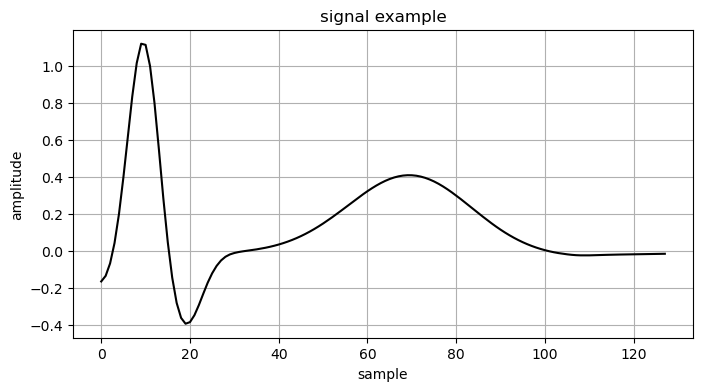

In [7]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(X[100], c='k')
ax.grid()
ax.set(title='signal example', ylabel='amplitude', xlabel='sample')

In [8]:
D = wavelet_basis(n, basis, level=2)

[Text(0.5, 1.0, 'DWT transform')]

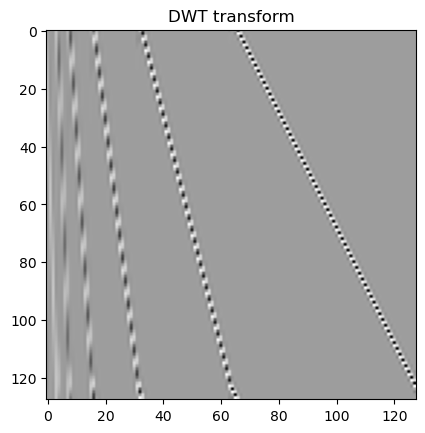

In [9]:
fig, ax = plt.subplots()
ax.imshow(D, cmap='gray')
ax.set(title='DWT transform')

In [10]:
A = generate_sensing_matrix((m, n), seed=seed)
cs = CompressedSensing(A, D)
Y = cs.encode(X)  # measurements

[Text(0.5, 1.0, 'Encoder')]

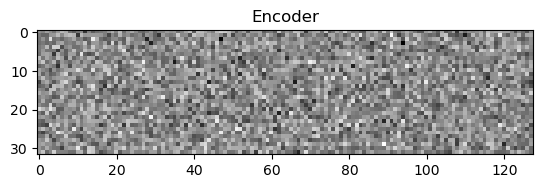

In [11]:
fig, ax = plt.subplots()
ax.imshow(A, cmap='gray')
ax.set(title='Encoder')

In [12]:
namefile = os.path.join('../../newpenny/dnn-cs/JETCAS2020/data/',f'n{n}_ISNR', f'trSet_n={n}_m={m}_isnr={isnr}-label.h5')
with pd.HDFStore(namefile, mode='r') as store:
    Z = store.select('S').values.squeeze()

# file_name = f'support_train_N={N}_n={n}_fs={fs}_hr={heart_rate[0]}-{heart_rate[1]}'\
#                 f'_isnr={isnr}_seed={seed}.pkl'
# data_path = os.path.join('training_data', file_name)
# if os.path.exists(data_path):
#     with open(data_path, 'rb') as f:
#         Z = pickle.load(f)
# else:
#     Z = np.array([find_support_TSOC(x, cs) for x in X])
#     with open(data_path, 'wb') as f:
#         pickle.dump(Z, f)

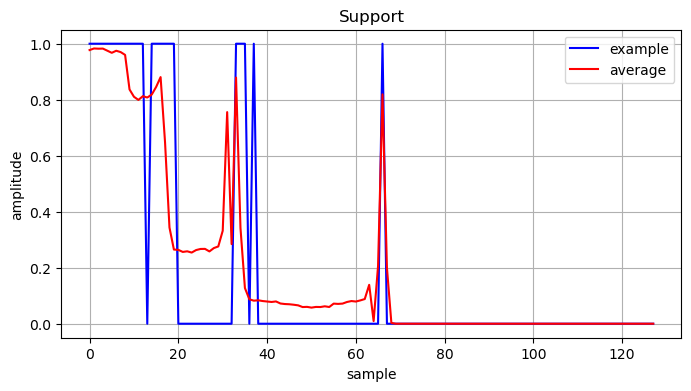

In [13]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(Z[100], c='b', label='example')
ax.plot(np.mean(Z, axis=0), c='r', label='average')
ax.set(title='Support',
       ylabel='amplitude', xlabel='sample')
ax.grid()
ax.legend()

In [14]:
dataset = TensorDataset(torch.from_numpy(Y).float(), torch.from_numpy(Z).float())  # Create a dataset from the tensors
# Split sizes for training and validation
train_size = int(train_fraction * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation

# Split the dataset
generator = torch.Generator()
generator.manual_seed(seed)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=generator)

# Create data loaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
# Y_val, Z_val = zip(*val_dataset)
# Y_val = torch.stack(Y_val)  # Combine list of tensors into one tensor
# Z_val = torch.stack(Z_val)

In [15]:
train_dataset.indices

[1136044,
 249580,
 1318167,
 899487,
 1054415,
 758079,
 1362819,
 431915,
 1291161,
 1098373,
 108711,
 1716425,
 334636,
 1110148,
 1664102,
 382311,
 734920,
 660357,
 1484400,
 1476553,
 1368926,
 1776675,
 1112703,
 11232,
 163664,
 1720041,
 661687,
 1881999,
 1102057,
 1327607,
 1823391,
 422458,
 1338835,
 812849,
 339017,
 1325825,
 121182,
 513765,
 1348457,
 1673001,
 422298,
 1174954,
 1035790,
 963362,
 384707,
 1086722,
 828473,
 1237540,
 697646,
 73541,
 1112190,
 1323085,
 114573,
 1464836,
 937455,
 1723605,
 1287583,
 783386,
 713880,
 1161516,
 93639,
 417068,
 416925,
 1644432,
 316823,
 1008550,
 1890028,
 1278134,
 904492,
 1425589,
 422067,
 672714,
 1330758,
 1099799,
 1214578,
 1323071,
 829303,
 788073,
 616157,
 300912,
 1339722,
 1699785,
 1818960,
 1626953,
 135721,
 824988,
 278191,
 689024,
 573923,
 946531,
 104265,
 686300,
 1130014,
 1227188,
 861683,
 33726,
 122990,
 146210,
 406531,
 1539977,
 5505,
 1644733,
 980340,
 1634017,
 665724,
 1583390,


## Network

In [16]:
tsoc = TSOC(n, m)
tsoc.to(device) # move the network to GPU
print(tsoc)
file_model = f'TSOC-N={N}_n={n}_fs={fs}_hr={heart_rate[0]}-{heart_rate[1]}'\
             f'_isnr={isnr}-epochs={epochs}-bs={batch_size}-opt=sgd-lr={lr}'\
             f'_th={threshold}_tf={train_fraction}_minlr={min_lr}-p={patience}'\
             f'_mind={min_delta}_seed={seed}.pth'

TSOC(
  (fc1): Linear(in_features=32, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=128, bias=True)
)


## Training

In [17]:
if os.path.exists(file_model):
    tsoc.load_state_dict(torch.load(file_model, weights_only=True))
else:
    optimizer = optim.SGD(tsoc.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=factor, threshold=min_delta, threshold_mode='abs', patience=patience//2, min_lr=min_lr)
    min_val_loss = np.inf
    patience_counter = 0
    # loss_fn = ClippedCrossEntropyLoss()

    for epoch in range(epochs):
        # train loop
        tsoc.train()     # Set the model to training mode
        train_loss = 0.0
        train_metrics = {'P': 0.0, 'TP': 0.0, 'TPR': 0.0, 'TNR': 0.0, 'ACC': 0.0}
        for batch_idx, (Y_batch, Z_batch) in enumerate(train_loader):
            Y_batch, Z_batch = Y_batch.to(device), Z_batch.to(device)     # move training data to GPU
            output = tsoc(Y_batch)
            loss = multiclass_loss_alpha(output, Z_batch)

            train_metrics_batch = compute_metrics(output, Z_batch, th=threshold)
            optimizer.zero_grad()     # zeroes the gradient buffers of all parameters
            loss.backward()     # Backpropagate
            optimizer.step()     # Update weights
            # check loss value
            if np.isnan(loss.item()) or np.isinf(loss.item()):
                print("Invalid loss, terminating training.")
                break
            train_loss += loss.item()
            train_metrics = update_metrics(train_metrics, train_metrics_batch)

        num_batches = len(train_loader)
        train_loss = train_loss/num_batches
        train_metrics = {key: value / num_batches for key, value in train_metrics.items()}

        # validation loop
        tsoc.eval()     # Set the model to evaluation mode
        val_loss = 0.0
        val_metrics = {'P': 0.0, 'TP': 0.0, 'TPR': 0.0, 'TNR': 0.0, 'ACC': 0.0}
        with torch.no_grad():     # disables gradient calculation for the validation phase 
            for batch_idx, (Y_batch, Z_batch) in enumerate(val_loader):
                Y_batch, Z_batch = Y_batch.to(device), Z_batch.to(device)     # move validation data to GPU
                output = tsoc(Y_batch)
                val_loss += multiclass_loss_alpha(output, Z_batch).item()
                val_metrics_batch = compute_metrics(output, Z_batch, th=threshold)
                val_metrics = update_metrics(val_metrics, val_metrics_batch)

        num_batches = len(val_loader)
        val_loss = val_loss/num_batches
        # callbacks
        # early stopping
        scheduler.step(val_loss)
        # early stopping
        if val_loss < min_val_loss - min_delta:
            min_val_loss = np.copy(val_loss)
            patience_counter = 0
        else:
            patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping")
            break
        val_metrics = {key: value / num_batches for key, value in val_metrics.items()}

        print(f"Epoch [{epoch+1}/{epochs}], LR={scheduler.get_last_lr()[0]}\nTRAIN Loss: {np.round(train_loss, 3)}  " +\
               "  ".join([f'{key}: {np.round(value, 3)}' for key, value in train_metrics.items()])  +\
                f"\n  VAL Loss: {np.round(val_loss, 3)}  " +\
                    "  ".join([f'{key}: {np.round(value, 3)}' for key, value in val_metrics.items()]) + "\n") 


    torch.save(tsoc.state_dict(), file_model)

Epoch [1/500], LR=0.1
TRAIN Loss: 0.048  P: 25.333  TP: 23.304  TPR: 0.924  TNR: 0.972  ACC: 0.961
  VAL Loss: 0.04  P: 25.334  TP: 23.897  TPR: 0.946  TNR: 0.974  ACC: 0.968

Epoch [2/500], LR=0.1
TRAIN Loss: 0.038  P: 25.333  TP: 23.902  TPR: 0.946  TNR: 0.976  ACC: 0.969
  VAL Loss: 0.036  P: 25.334  TP: 23.946  TPR: 0.948  TNR: 0.977  ACC: 0.97



KeyboardInterrupt: 

In [ ]:
Y_val, Z_val = zip(*val_dataset)
Y_val = torch.stack(Y_val)  # Combine list of tensors into one tensor
Z_val = torch.stack(Z_val)

Y_val, Z_val = Y_val.to(device), Z_val.to(device)     # move validation data to GPU
output = tsoc(Y_val)
val_metrics = compute_metrics(output, Z_val, th=threshold)

In [ ]:
val_metrics

{'P': 25.33363151550293,
 'TP': 23.962175369262695,
 'TPR': 0.9489148259162903,
 'TNR': 0.9841780066490173,
 'ACC': 0.9764326810836792}